<a href="https://colab.research.google.com/github/PashaIanko/RestrictedBolzmannMachine/blob/main/Omniglot_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Helper links:
- https://github.com/pytorch/vision/blob/main/torchvision/datasets/omniglot.py

In [4]:
%%html
<marquee style='width: 60%; color: blue;'><b>Ladies and Gentlemen! To my pleasure - Cogn & Comp 2021 project!</b></marquee>

## **Packages, Constants & Functions**

In [5]:
# Preprocessing
CROP_SIZE_ = 90
MEAN_ = 0.5
STD_ = 0.5
IMG_SIZE_ = CROP_SIZE_

# Train
EPOCHS_ = 300
BATCH_SIZE_ = 80
LABEL_FROM_ = 0
LABEL_TO_ = 28
LABEL_MIN_ = 0
LABEL_MAX_ = 963

# Receprive fields visualization
VISUALIZATION_THRESH_ = .08

# Alphabets
# key - alphabet, value - start and finish labels
ALPHABETS_DICT_ = {
    'First': [0, 25]  # Label limits
}

# Model
VISIBLE_UNITS_ = IMG_SIZE_ * IMG_SIZE_
HIDDEN_UNITS_ = [500, 500, 1200]
N_HIDDEN_LAYERS_ = len(HIDDEN_UNITS_)
K_ = 1
LEARNING_RATE_ = 0.07
LR_DECAY_ = False
INIT_MOMENTUM_ = 0.5
FIN_MOMENTUM_ = 0.9
W_DECAY_ = 0.00002
XAVIER_INIT_ = False
INCREASE_TO_CD_K_ = False
USE_GPU_ = True

In [6]:
%%capture

url_dbn = 'https://raw.githubusercontent.com/PashaIanko/RestrictedBolzmannMachine/main/DBN.py'
url_rbm = 'https://raw.githubusercontent.com/PashaIanko/RestrictedBolzmannMachine/main/RBM.py'

utils = {
    'DBN.py': url_dbn,
    'RBM.py': url_rbm
}

for file, url in utils.items():
    !wget -O {file} {url} {file}

In [7]:
import torch
import torchvision as tv
from torchvision import datasets

# Models
from DBN import DBN

# Plotting
import matplotlib.pyplot as plt

# Download
from google.colab import drive
from os import path

# Utils
import numpy as np
import random
import math

In [8]:
def fix_seeds():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

In [9]:
def visualize_symbols(dataset, n_subplots, image_shape):
    n_rows_cols = int(math.sqrt(n_subplots))
    fig, axes = plt.subplots(
        n_rows_cols, 
        n_rows_cols, 
        sharex = True,
        sharey = True,
        figsize = (10, 10)
    )
    for i in range(n_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        img, _ = dataset[i] 
        axes[row, col].imshow(torch.flatten(img).reshape(image_shape), cmap='binary')

In [10]:
def find_image(ds, label):
    for item in ds:
        if item[1] == label:
            return item[0]

def visualize_letters(labels, image_shape, ds):
    n_subplots = len(labels)
    
    n_rows_cols = int(math.sqrt(n_subplots))
    fig, axes = plt.subplots(
        n_rows_cols, 
        n_rows_cols, 
        sharex = True,
        sharey = True,
        figsize = (10, 10)
    )

    for i in range(n_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        label = labels[i]
        
        image = find_image(ds, label)
        axes[row, col].imshow(torch.flatten(image).reshape(image_shape), cmap='binary')

def prepare_data(ds, label_from, label_to):
    labels = []
    images = []
    for item in ds:
        if label_from <= item[1] <= label_to:
            labels.append(item[1])
            images.append(item[0])
    return images, labels

In [11]:
def move_parameters_to_cpu(dbn_mnist):
    for layer in dbn_mnist.rbm_layers:
        layer.W = layer.W.cpu()
        layer.h_bias = layer.h_bias.cpu()
        layer.v_bias = layer.v_bias.cpu()

def apply_threshold(weights, threshold=0):
    return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights_matrices, num_subplots = 64, 
                                img_width=IMG_SIZE_, img_height=IMG_SIZE_, 
                                fig_size = (20, 20)):
    n_rows_cols = int(math.sqrt(num_subplots))
    fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=fig_size)
    for i in range(num_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        
        # Matrix of connection strength (W) of i-th unit of the layer.
        # Reshape from 'linear' to 'image' representation
        W_matrix = weights_matrices[i, :].reshape((img_height, img_width))
        axes[row, col].imshow(W_matrix, cmap = plt.cm.gray)

In [31]:
def project_hidden_layer(weights_matrices, layer_numb):
    
    # layer_numb starts from 2 (number of hidden layer)
    
    layers = weights_matrices[:layer_numb]
    cur_layer = layers[0]
    for i in range(1, len(layers)):
        cur_layer = layers[i] @ cur_layer
    return cur_layer

## **Data Download**

- For neural networks, we need to scale data before learning
- Need to obtain tensor shape
- Fix seeds for reproducibility

In [12]:
%%capture 

fix_seeds()

transformer = tv.transforms.Compose(
    [
        tv.transforms.CenterCrop(CROP_SIZE_),
        tv.transforms.ToTensor(),
        
        # Transform to {-1, 1} binary image
        tv.transforms.Normalize(mean=(MEAN_,), std=(STD_),)  
    ]
)

train = datasets.Omniglot(
    root = '/content/',
    download = True,
    background = True,
    transform = transformer
)

test = datasets.Omniglot(
    root = '/content/',
    download = True,
    background = False,
    transform = transformer
)

Image shape = torch.Size([1, 90, 90])


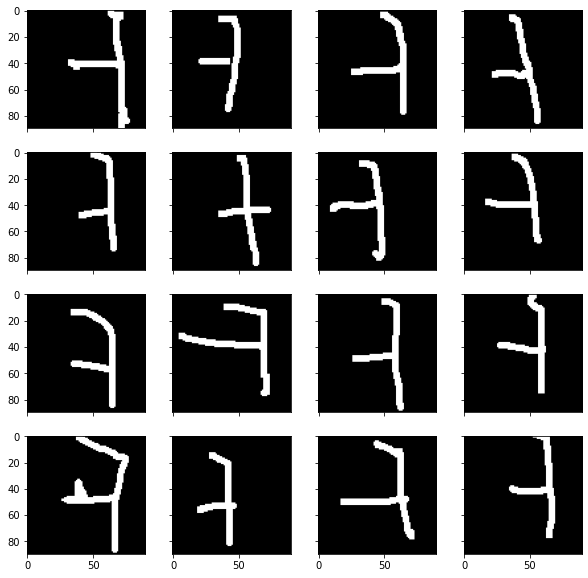

In [13]:
img, _ = train[0]
print(f'Image shape = {img.shape}')
visualize_symbols(train, 16, image_shape = (CROP_SIZE_, CROP_SIZE_))

In [14]:
# __getitem__ structure - tensor (image) + label (one label for 20 images of single letter)
train.__getitem__(19)

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]), 0)

## **Visualize Data (alphabets)**

- 1st conclusion:  
    - 1 Dataset
    - 50 Alphabets
    - 20-30 characters in each (varies)
    - 20 images for one character
    - First 20 images (from 0 to 19) are labeled '0' (first character),
        then next character is labeled '1' and so on
    - 964 unique labels


In [15]:
print(f'Available alphabets:')
for alph in train._alphabets: print(alph)

Available alphabets:
Korean
Mkhedruli_(Georgian)
Hebrew
Blackfoot_(Canadian_Aboriginal_Syllabics)
Tifinagh
Balinese
Futurama
Anglo-Saxon_Futhorc
Sanskrit
Japanese_(hiragana)
Ojibwe_(Canadian_Aboriginal_Syllabics)
Malay_(Jawi_-_Arabic)
Tagalog
Cyrillic
Inuktitut_(Canadian_Aboriginal_Syllabics)
Gujarati
Early_Aramaic
Grantha
Syriac_(Estrangelo)
N_Ko
Bengali
Braille
Greek
Alphabet_of_the_Magi
Armenian
Burmese_(Myanmar)
Asomtavruli_(Georgian)
Japanese_(katakana)
Arcadian
Latin


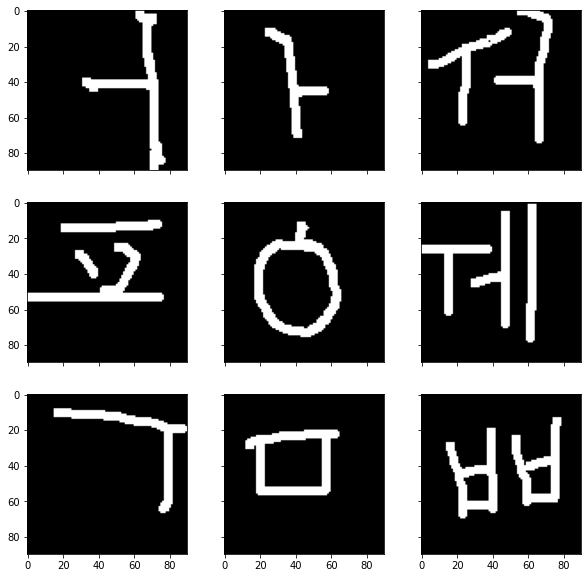

In [16]:
# Visualize first few letters of one alphabet
visualize_letters(
    labels = [0, 1, 2,
              3, 4, 5,
              6, 7, 8
              ],
    
    image_shape = (IMG_SIZE_, IMG_SIZE_),
    ds = train
)

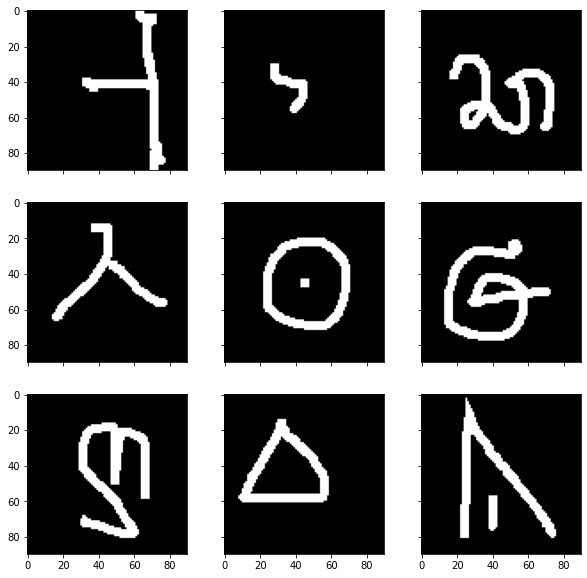

In [17]:
# Visualize letters of different alphabets 
visualize_letters(
    labels = [
              0, 30, 60,
              90, 120, 150,
              180, 210, 240
              ],
    image_shape = (IMG_SIZE_, IMG_SIZE_),
    ds = train
)

## **Prepare Data (Select alphabets & labels)**

In [19]:
# Slice and choose only subset of certain alphabet labels
images, labels = prepare_data(
    train, 
    label_from = LABEL_FROM_,  
    label_to = LABEL_TO_
)
print(f'Size of the dataset = {len(labels)}')

Size of the dataset = 580


In [20]:
# To Tensors
labels = torch.FloatTensor(labels)
buffer = torch.Tensor(len(images), IMG_SIZE_, IMG_SIZE_)
torch.cat(images, out=buffer)
images = buffer

In [21]:
print(type(labels), type(images))
print(type(labels[0]), type(images[0]))

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


## **Deep Belief Network model & fit**

- Deep Belief Network - a stack of Restricted Bolzmann Machines
    - RBM is a bipartite graph with input and hidden layer
    - Hidden layer captures dependencies and features
- Each layer learns more complex and abstract features
- Used as feature extraction method (generative model)
- No output neurons
- Two phases (negative & positive) during learning (reconstruction)




In [22]:
fix_seeds()

model = DBN(
    visible_units = VISIBLE_UNITS_,
    hidden_units = HIDDEN_UNITS_,
    k = K_,
    learning_rate = LEARNING_RATE_,
    learning_rate_decay = LR_DECAY_,
    initial_momentum = INIT_MOMENTUM_,
    final_momentum = FIN_MOMENTUM_,
    weight_decay = W_DECAY_,
    xavier_init = XAVIER_INIT_,
    increase_to_cd_k = INCREASE_TO_CD_K_,
    use_gpu = USE_GPU_
)

In [23]:
fix_seeds()

model.train_static(
    images,
    labels,
    EPOCHS_,
    BATCH_SIZE_
)

move_parameters_to_cpu(model)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |34.0300   |5.3418   |9777.2500 |705.5922   |
|20    |33.9459   |5.3573   |8614.7627 |719.1871   |
|30    |33.9897   |5.3082   |8226.6719 |641.3217   |
|40    |34.0239   |5.2885   |8232.7432 |634.5297   |
|50    |34.0468   |5.2947   |8254.9609 |639.9152   |
|60    |34.0794   |5.3063   |8417.9561 |613.5863   |
|70    |34.1218   |5.2581   |7703.5972 |381.6790   |
|80    |32.0272   |5.3552   |2431.9480 |298.7427   |
|90    |32.0056   |5.3537   |2367.0730 |293.8823   |
|100    |32.0035   |5.3523   |2436.9021 |257.7770   |
|110    |32.0056   |5.3537   |2364.3337 |293.6502   |
|120    |32.0056   |5.3537   |2363.0950 |293.6801   |
|130    |32.0056   |5.3537   |2361.7615 |293.6794   |
|140    |32.0052   |5.3531   |2402.9607 |300.4318   |
|150    |32.0057   |5.3537   |2359.5227 |293.6861   |
|160    |32.1613   |5.3567   |2512.9165 |309.8095   |
|170    |32.1593   |5.3572   |2510.6074 |309.

## **Linear read-outs. Receptive fields visualization**

Lets understand the structure of network & layers
- Input layer size - (IMG_SIZE_ * IMG_SIZE_)
- 0-level of RBM network with N units -> has connection matrix W. 
Size of W = N_units * (IMG_SIZE_ * IMG_SIZE_)
- We can consider W matrix of 0-level as N "images" of size (IMG_SIZE_ * IMG_SIZE_)
- Hence, we can visualize connection strengths, starting from 0 hidden level

In [24]:
print(type(model.rbm_layers[0].W))
print(type(model.rbm_layers[0].W.numpy()))
print(model.rbm_layers[0].W.size())
print(model.rbm_layers[1].W.size())

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
torch.Size([8100, 500])
torch.Size([500, 500])


### Preprocessing (filtering) learned weights matrices

In [25]:
# Converting and processing W matrices of hidden layers

learned_weights = [
    model.rbm_layers[i].W.transpose(0, 1).numpy() for i in range(N_HIDDEN_LAYERS_)  # We transpose for convenience (matrices[i, :] is more intuitive than matrices[:, i])
]

learned_weights_thresh = [apply_threshold(weights_matrix, VISUALIZATION_THRESH_) for weights_matrix in learned_weights]

### First hidden layer receptive fields

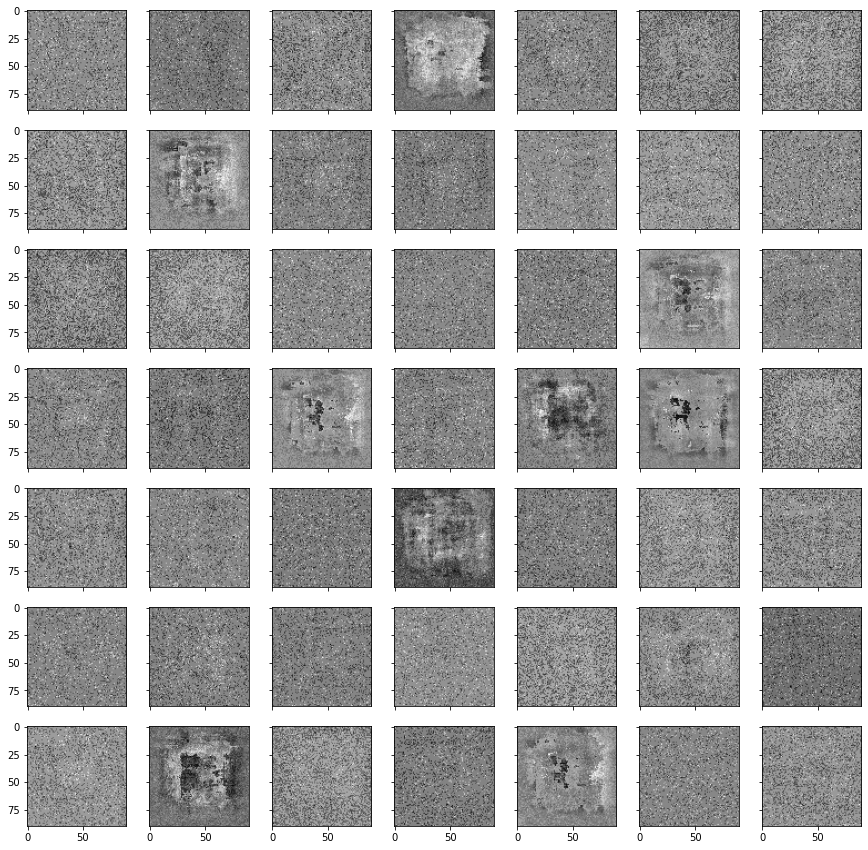

In [26]:
plot_layer_receptive_fields(
    learned_weights_thresh[0],  # N_units * (img_size * img_size) - dimension of 1st hidden layer
    num_subplots=49,
    img_height = IMG_SIZE_,
    img_width = IMG_SIZE_, 
    fig_size = (15, 15)
)

### Second hidden layer receptive field

- For example, in the architecture with units = [500, 500, 2000], the second hidden layer consists of 500 units, each associated with 500 units of the 1st hidden layer (500 x 500 matrix)
- We need to visualize (IMG_SIZE_ * IMG_SIZE_) images of 2nd hidden layer receptive fields
- The dimension of 1st hidden layer is n_units * (IMG_SIZE * IMG_SIZE).
- **Therefore**, we need to perform matrix multiplication, to turn (500 x 500) layer to (500 x (IMG_SIZE x IMG_SIZE)) layer

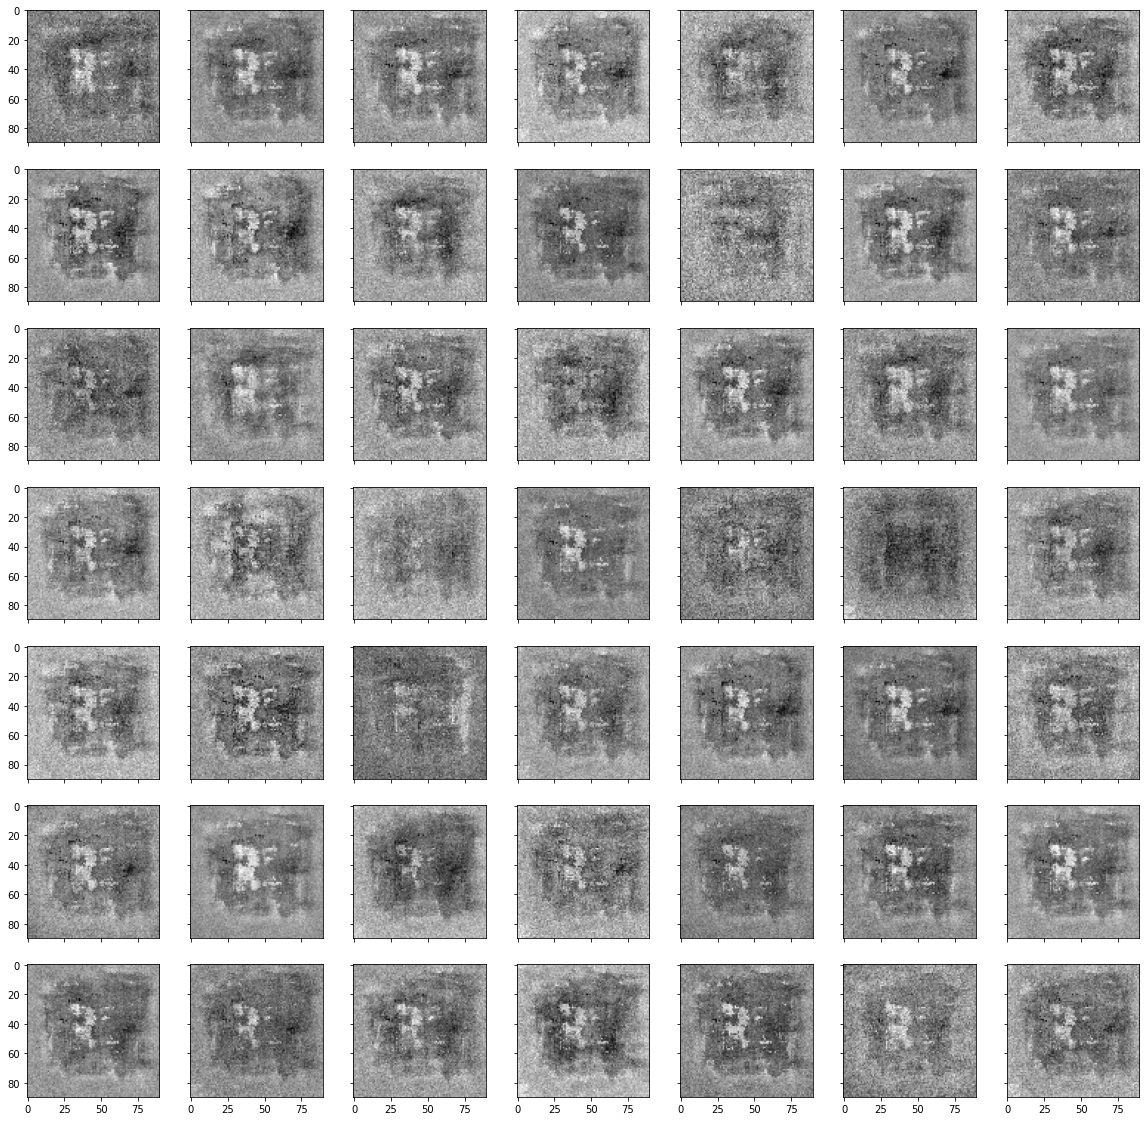

In [29]:
plot_layer_receptive_fields(
    project_hidden_layer(
        learned_weights_thresh,
        layer_numb = 2
    ), 
    num_subplots = 49
)

### Third hidden layer receptive fields

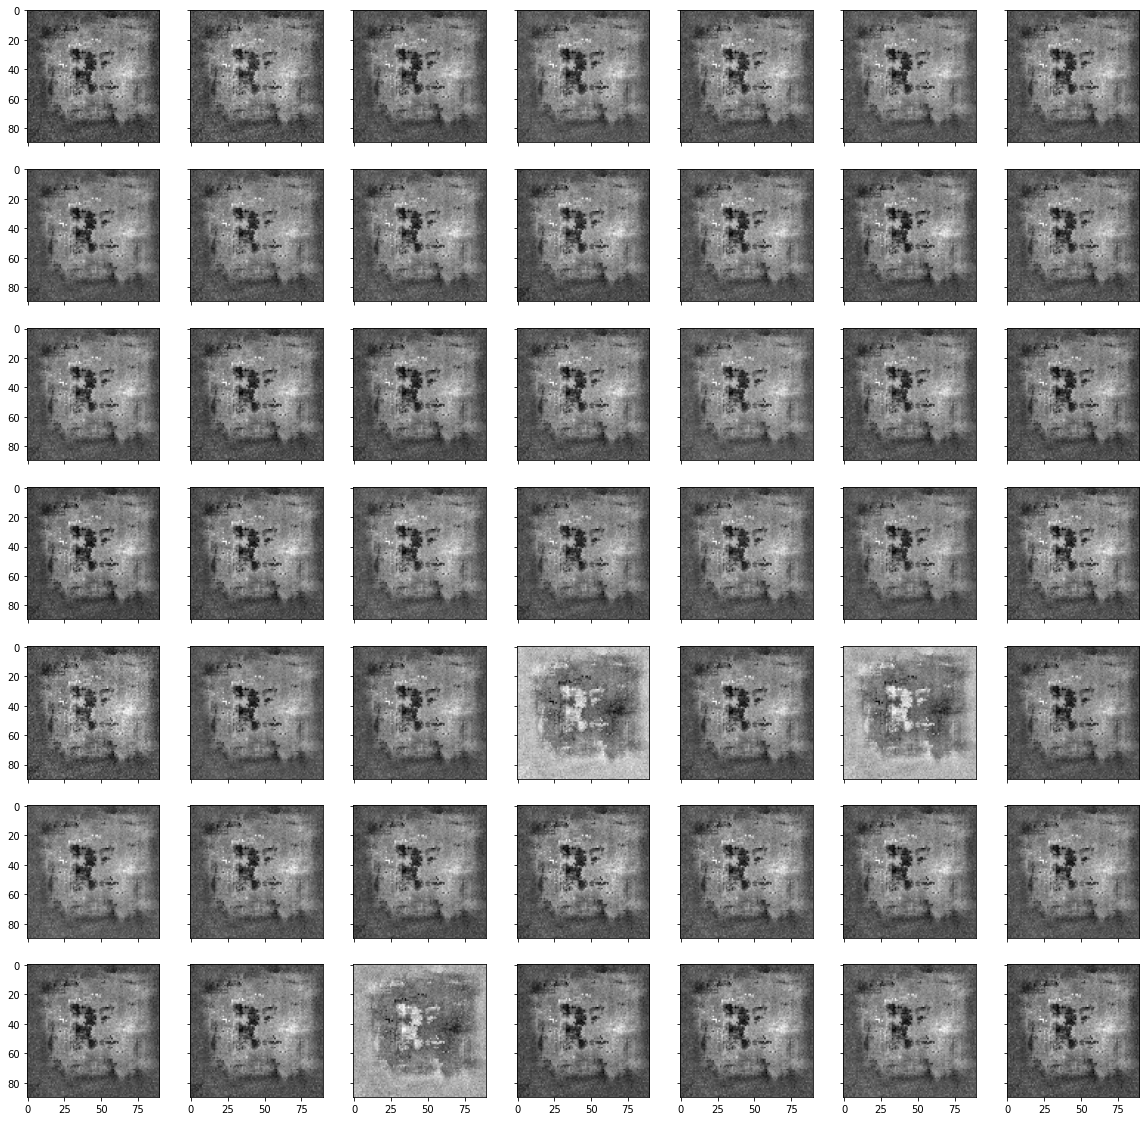

In [30]:
plot_layer_receptive_fields(
    project_hidden_layer(
        learned_weights_thresh,
        layer_numb = 3
    ), 
    num_subplots = 49
)